In [9]:
from importlib import reload
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import utils as u
import seaborn as sns
from IPython.core.display import display, HTML

In [10]:
reload(u)

<module 'utils' from '/home/andrew/projects/boardgames/utils.py'>

In [11]:
# Get all the xml file names
xml_data_files = ["./data/"+file for file in os.listdir("./data/") if file.endswith('.xml')]
xml_data_files.sort()
# Extract the data into a single dataframe
data_kwargs = {'id':True, 'year_published':True}
df = pd.concat([pd.DataFrame(u.extract_xml(file, **data_kwargs)) for file in xml_data_files], axis=0)


In [12]:
print("Summary \n------")
print(f"{df.shape[0]} items. {df.duplicated().sum()} duplicates.")
print(f"{(df['year_published'] == 0).sum()} missing year published info.")

Summary 
------
1171 items. 4 duplicates.
115 missing year published info.


In [13]:
clean_df = df.drop_duplicates().query("year_published != 0")

In [14]:
clean_df.year_published.describe()

count    1052.000000
mean     2002.597909
std        45.345706
min       700.000000
25%      1999.000000
50%      2010.000000
75%      2017.000000
max      2023.000000
Name: year_published, dtype: float64

In [25]:
def plot_year_hist(df: pd.DataFrame,
                   year_published_key: str = 'year_published',
                   n_bins: int = 50,
                   bin_range: tuple[float, float] = None):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(x=year_published_key,
                               data=df,
                               range=bin_range,
                               bins=n_bins)

    return ax

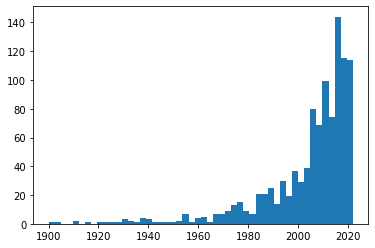

In [28]:
test = plot_year_hist(clean_df, bin_range=(1900, 2022))

In [17]:
clean_df.id[clean_df.year_published < 1000]

102    2448
Name: id, dtype: int64

In [18]:
u.display_id_link(2448)

